## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests
from datetime import datetime, timedelta
%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [2]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
2832335,412173,12595,81,6668,100.0
4289388,472952,11863,142,823,0.0
517540,606983,14598,140,603,12.0
584969,404844,9728,98,7206,100.0
5257720,483226,172,32,7999,100.0


Сделаем разбиение по времени

<Axes: >

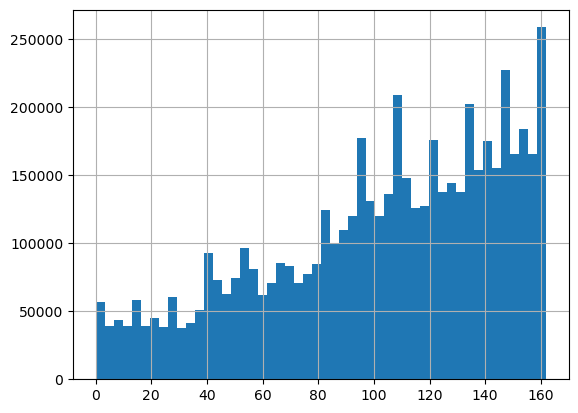

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там, и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там, и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
47,163922,1931,45,155,0.0
58,739920,3190,145,3349,48.0
97,1061176,13763,150,1084,16.0
187,138337,11134,145,614,14.0
189,969875,372,122,567,12.0


In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

C:\Users\vdl\AppData\Local\Temp\ipykernel_4992\1105526701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
C:\Users\vdl\AppData\Local\Temp\ipykernel_4992\1105526701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1..."
1,181,"[(12192, 145), (10440, 145), (13018, 146), (41..."
2,229,"[(11275, 110), (4151, 110), (1699, 126), (1460..."
3,373,"[(2154, 120)]"
4,419,"[(4716, 94), (4151, 106), (15297, 109), (16270..."


In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]"
1,181,"[(12192, 145), (10440, 145), (13018, 146), (41...","[(16228, 159), (4880, 160)]"
2,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]"
3,373,"[(2154, 120)]","[(3734, 157)]"
4,419,"[(4716, 94), (4151, 106), (15297, 109), (16270...","[(341, 159)]"


In [11]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]","[9070, 15772, 6876]"
1,181,"[(12192, 145), (10440, 145), (13018, 146), (41...","[(16228, 159), (4880, 160)]","[9070, 15772, 6876]"
2,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[9070, 15772, 6876]"
3,373,"[(2154, 120)]","[(3734, 157)]","[9070, 15772, 6876]"
4,419,"[(4716, 94), (4151, 106), (15297, 109), (16270...","[(341, 159)]","[9070, 15772, 6876]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [12]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    gt_items = np.array(gt_items)
    predictions = np.array(predictions[:topn])
    is_relevant = np.in1d(predictions, gt_items)
    
    relevant_indices = np.where(is_relevant)[0]
    
    if len(relevant_indices) == 0:
        return 0.0

    precision_at_k = ((np.ones(len(predictions)) * is_relevant).cumsum() * is_relevant) / (np.arange(1, len(predictions) + 1))
    
    return precision_at_k[relevant_indices].sum() / (len(gt_items) if topn == None or len(gt_items) < topn else topn)

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if len(set(gt_items) & set(predictions[:topn])) == 0:
        return 0
    
    gt_items = np.array(gt_items)
    predictions = np.array(predictions[:topn])
    first_relevant = min(np.where(np.in1d(predictions, gt_items))[0]) + 1
    
    return 1. / first_relevant

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    return min(len(set(gt_items) & set(predictions[:topn])), 1)


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [13]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [14]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [15]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0013484453234767636, 'mrr': 0.005833333333333333, 'hr': 0.0065}

In [16]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)
    
    def get_metrics(self, df, model_preds, gt_col='test_interactions'):
        metric_values = []

        for idx, row in df.iterrows():
            gt_items = [x[0] for x in row[gt_col]]
            predictions = model_preds
            ap = ap_metric(gt_items, predictions)
            rr = rr_metric(gt_items, predictions)
            hr = hr_metric(gt_items, predictions)
    
            metric_values.append((ap, rr, hr))
    
        return np.mean([x[0] for x in metric_values]), np.mean([x[1] for x in metric_values]), np.mean([x[2] for x in metric_values])


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]","[9070, 15772, 6876]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,181,"[(12192, 145), (10440, 145), (13018, 146), (41...","[(16228, 159), (4880, 160)]","[9070, 15772, 6876]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[9070, 15772, 6876]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,373,"[(2154, 120)]","[(3734, 157)]","[9070, 15772, 6876]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,419,"[(4716, 94), (4151, 106), (15297, 109), (16270...","[(341, 159)]","[9070, 15772, 6876]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [17]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06619583929309511, 'mrr': 0.11981119047619047, 'hr': 0.2784}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [18]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        counts = {}
        for _, row in df.iterrows():
            for item, window in row[col]:
                if window <= self.min_window:
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return self.recommenations[:topn]
    
    def get_metrics(self, df, model_preds, gt_col='test_interactions'):
        metric_values = []

        for idx, row in df.iterrows():
            gt_items = [x[0] for x in row[gt_col]]
            predictions = model_preds
            ap = ap_metric(gt_items, predictions)
            rr = rr_metric(gt_items, predictions)
            hr = hr_metric(gt_items, predictions)
    
            metric_values.append((ap, rr, hr))
    
        return np.mean([x[0] for x in metric_values]), np.mean([x[1] for x in metric_values]), np.mean([x[2] for x in metric_values])

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [19]:
df_with_windows = {'window': [], 
                   'ap_metric': [], 
                   'rr_metric': [], 
                   'hr_metric': []}
for window in tqdm(range(2, 200, 15)):
    df_with_windows['window'].append(window)
    toppop_in_win = TopPopularWeighted(min_window=window)
    toppop_in_win.fit(joined)
    ap, rr, hr = toppop_in_win.get_metrics(joined, toppop_in_win.predict(joined))
    df_with_windows['ap_metric'].append(ap)
    df_with_windows['rr_metric'].append(rr)
    df_with_windows['hr_metric'].append(hr)

  0%|          | 0/14 [00:00<?, ?it/s]

In [20]:
df_with_windows = pd.DataFrame(df_with_windows, index=range(len(df_with_windows['window'])))

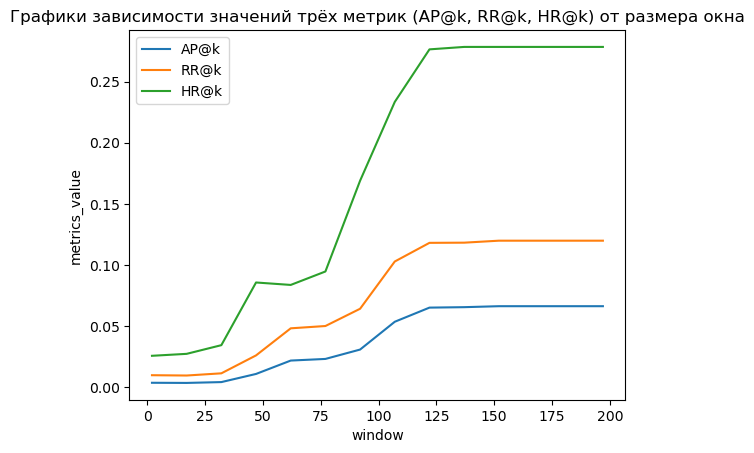

In [21]:
plt.plot(df_with_windows.window, df_with_windows.ap_metric, label='AP@k')
plt.plot(df_with_windows.window, df_with_windows.rr_metric, label='RR@k')
plt.plot(df_with_windows.window, df_with_windows.hr_metric, label='HR@k')
plt.title('Графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна')
plt.xlabel('window')
plt.ylabel('metrics_value')
plt.legend()
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**

С ростом окна увеличивается выборка взаимодействий юзера с айтемами, а с ростом числа объектов увеличивается вероятность совпадений с предиктом

Наилучшее значение соответствует наибольшему окну (если у юзера не изменились предпочтения)

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [22]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [23]:
df_per_topn = {'k': [], 
                'ap_metric': [], 
                'rr_metric': [], 
                'hr_metric': []}
for topn in tqdm(range(1, 300, 2)):
    df_per_topn['k'].append(topn)
    toppop_per_topn = TopPopular()
    toppop_per_topn.fit(joined)
    ap, rr, hr = toppop.get_metrics(joined, toppop_per_topn.predict(joined, topn=topn)[0])
    df_per_topn['ap_metric'].append(ap)
    df_per_topn['rr_metric'].append(rr)
    df_per_topn['hr_metric'].append(hr)

  0%|          | 0/150 [00:00<?, ?it/s]

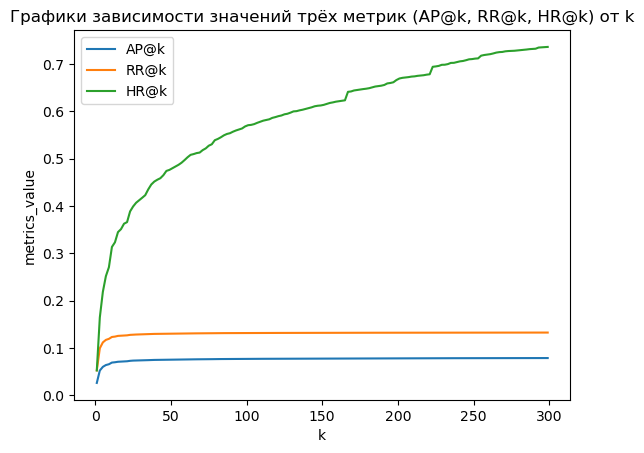

In [24]:
plt.plot(df_per_topn['k'], df_per_topn['ap_metric'], label='AP@k')
plt.plot(df_per_topn['k'], df_per_topn['rr_metric'], label='RR@k')
plt.plot(df_per_topn['k'], df_per_topn['hr_metric'], label='HR@k')
plt.title('Графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от k')
plt.xlabel('k')
plt.ylabel('metrics_value')
plt.legend()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \

Все функции монотонные. Связано это с тем, что количество совпавших айтемов не может падать с ростом числа предсказаний

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \

ap - метрика резко растет, т.к. рост числа предсказаний обеспечивает рост верно предсказанных айтемов, но затем рост останавливается из-за конечного количества взаимодействий юзера и определенного качества предсказания. Метрика бы остановила рост на 1, если бы была идеальна

rr - метрика также как ap резко растет, т.к. рост числа предсказаний обеспечивает снижение индекса первого верно предсказанного айтема, но рост ограничен количеством взаимодействий и определенного качества предсказания. Метрика бы остановила рост на 1, если бы была идеальна, т.к. рано или поздно 1 просмотренных юзером айтем все-таки совпал бы

hr - метрика постоянно растет, т.к. с ростом числа предсказаний, вероятность хотя бы одного совпадения стремится к 1

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\

ap, rr стремятся к некоему истинному качеству предсказывающей модели, а hr к 1. Таким образом графики выглядят как и должны

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [25]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

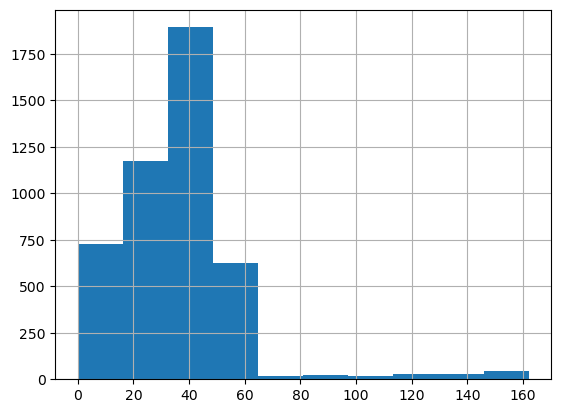

In [26]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

In [38]:
min_date = pd.to_datetime(pd.read_csv('interactions.csv').iloc[:-1]['last_watch_dt']).min()

Даты, между которыми ориентировочно начинается резкое падение популярности фильма 1917:

In [50]:
str(min_date + timedelta(50)).split()[0], str(min_date + timedelta(60)).split()[0]

('2021-05-02', '2021-05-12')

In [28]:
interactions.last_watch_dt = min_date + interactions.last_watch_dt.astype('timedelta64[D]')
interactions

,user_id,item_id,last_watch_dt,total_dur,watched_pct
834,65061,3402,2021-03-31,755,11.0
2204,880459,3402,2021-04-05,15,0.0
2842,664215,3402,2021-04-13,6227,87.0
3100,461478,3402,2021-04-04,8652,100.0
3280,408707,3402,2021-04-19,442,6.0
...,...,...,...,...,...
5471701,454026,3402,2021-05-01,7983,100.0
5472063,911028,3402,2021-04-24,6270,88.0
5474568,169048,3402,2021-03-15,10352,100.0
5475945,413378,3402,2021-03-21,7204,100.0


In [48]:
# Функция для вывода шести фильмов по 3 в ряд
def get_film_hist(df, sampled_id_1, sampled_id_2, sampled_id_3):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    interactions = df.loc[df.item_id==sampled_id_1].copy()
    interactions.last_watch_dt = min_date + interactions.last_watch_dt.astype('timedelta64[D]')
    name = items.loc[items.item_id==sampled_id_1].title.values[0]
    axes[0].hist(interactions.last_watch_dt)
    axes[0].set_title(f'Изменение популярности фильма\n"{name}" (id {sampled_id_1})')
    axes[0].set_xlabel('datetime')
    axes[0].set_ylabel('density')
    axes[0].tick_params(axis='x', rotation=45)

    interactions = df.loc[df.item_id==sampled_id_2].copy()
    interactions.last_watch_dt = min_date + interactions.last_watch_dt.astype('timedelta64[D]')
    name = items.loc[items.item_id==sampled_id_2].title.values[0]
    axes[1].hist(interactions.last_watch_dt)
    axes[1].set_title(f'Изменение популярности фильма\n"{name}" (id {sampled_id_2})')
    axes[1].set_xlabel('datetime')
    axes[1].set_ylabel('density')
    axes[1].tick_params(axis='x', rotation=45)

    interactions = df.loc[df.item_id==sampled_id_3].copy()
    interactions.last_watch_dt = min_date + interactions.last_watch_dt.astype('timedelta64[D]')
    name = items.loc[items.item_id==sampled_id_3].title.values[0]
    axes[2].hist(interactions.last_watch_dt)
    axes[2].set_title(f'Изменение популярности фильма\n"{name}" (id {sampled_id_3})')
    axes[2].set_xlabel('datetime')
    axes[2].set_ylabel('density')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

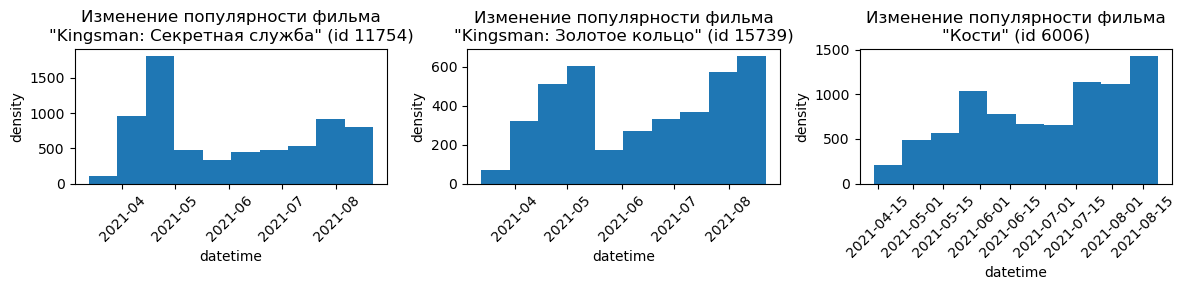

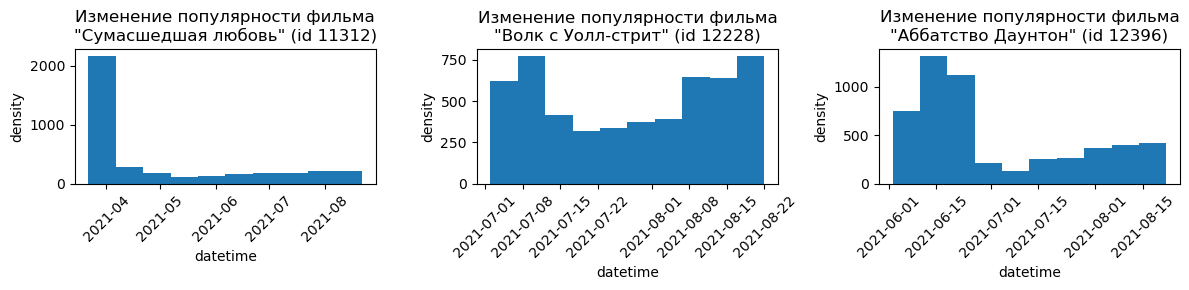

In [ ]:
# Так я искал подходящую выборку фильмов (+ вместо дельты времени вернул даты)
get_film_hist(df, np.random.choice(popular_items), np.random.choice(popular_items), np.random.choice(popular_items))
get_film_hist(df, np.random.choice(popular_items), np.random.choice(popular_items), np.random.choice(popular_items))

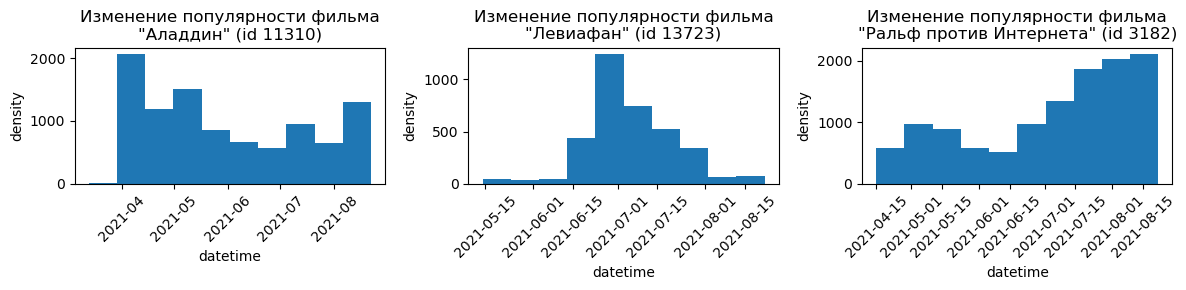

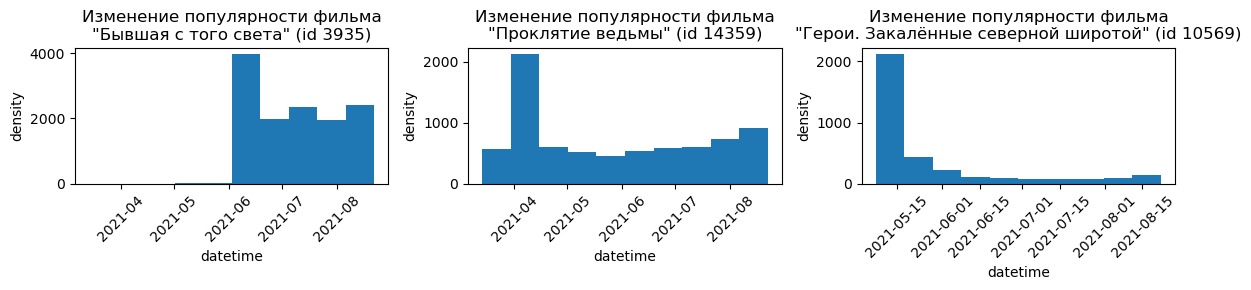

In [51]:
# Спустя некоторое количество итераций остановился на следующем наборе фильмов:
get_film_hist(df, 11310, 13723, 3182)
get_film_hist(df, 3935, 14359, 10569)

- Алладин, 11310 - Популярность фильма сначала медленно падает, затем начинает так же медленно расти. Возможно, это связано с тем, что фильм только стал доступен для просмотра, прошла волна просмотров, затем активность упала, а потом могла подействовать реклама или юзеры начали пересматривать;
- Левиафан, 13723 - Популярность фильма резко возросла, затем быстро упала, при это резкий рост произошел не с нуля. Скорее всего, прошла крупная рекламная кампания, которая не дала длительного эффекта (или дело в номинации на Оскар);
- Ральф против Интернета, 3182 - Популярность фильма держится примерно на одном уровне, затем начинает расти. Возможно, прошла рекламная кампания, которая оказалась эффективной;
- Бывшая с того света, 3935 - Популярность резко возросла с определенного момента, но не с нуля. Возможно, фильм стал доступен на сервисе, но из-за низкой популярности самого фильма, узнали о нём только после рекламы на сервисе, которая началась не сразу;
- Проклятие ведьмы, 14359 - Динамика популярности схожа с Левиафаном, поэтому пропущу его;
- Герои. Закаленные северной широтой, 10569 - Популярность фильма начинается с высоких значений, затем резко падает и остается на низком уровне. Возможно, фильм только стал доступен на сервисе, но юзерам оказался неинтересен

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [52]:
def filter_column(col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """

def filter_dataframe(df_tek, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """

filtered_train = filter_dataframe(df, ['user_id', 'item_id'], 4)

In [53]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.item_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df

filtered_train = df_encode(filtered_train)
filtered_train.sample(5)

AttributeError: 'NoneType' object has no attribute 'item_id'

In [ ]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(train_df_f.shape[0]), (train_df_f['user_id'], train_df_f['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<5890x3051 sparse matrix of type '<class 'numpy.float64'>'
	with 107108 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [ ]:
# your code here

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [ ]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):

    # your code here

    return B

w = fit_ease(matrix)

CPU times: user 5.12 s, sys: 555 ms, total: 5.67 s
Wall time: 3.24 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [ ]:
def get_preds(x, item2id, id2item):

    #your code here

    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,temp,inter_len,ease_preds
0,179,"[(14, 75), (13865, 95), (10440, 95), (9728, 97)]","[(15297, 157)]","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",1,"[15297, 9728, 10440, 13865, 3734, 9996, 2657, ..."
1,304,"[(11985, 71), (2301, 71), (175, 75), (4457, 99...","[(6054, 161), (4073, 161)]","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",2,"[13865, 10440, 7829, 9728, 3734, 7793, 12995, ..."
2,415,"[(3734, 105), (7571, 108), (8442, 110), (4457,...","[(12527, 154), (5330, 162), (16152, 162), (103...","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",4,"[9728, 10440, 3734, 4880, 15297, 13865, 4151, ..."
3,425,"[(10440, 142)]","[(12360, 156)]","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",1,"[15297, 13865, 9728, 2657, 4151, 9996, 142, 12..."
4,514,"[(5807, 113), (13865, 127)]","[(7728, 156), (1453, 158)]","[7409, 3306, 14709]","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...","[10440, 9728, 15297, 13865, 3734, 4151, 2657, ...",2,"[9728, 10440, 3734, 15297, 12995, 8636, 4495, ..."


In [ ]:
# your code here

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [ ]:
#your code here

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:**

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:**

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [ ]:
# your code here

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**